In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
df = pd.read_csv('transitions.csv', parse_dates=['day'])

In [3]:
df

,day,pre,post,channels,avg_twitch_revenue_3y
0,2015-01-01,small part-time,small part-time,12149,597.48
1,2015-01-01,small part-time,reengaged,199,237.82
2,2015-01-01,small part-time,large full-time,259,39253.83
3,2015-01-01,small part-time,infrequent,5862,64.70
4,2015-01-01,small part-time,large part-time,374,17518.31
5,2015-01-01,small part-time,cold,7099,130.47
6,2015-01-01,small part-time,small full-time,1116,3054.74
7,2015-01-01,small part-time,frozen,39400,38.43


In [4]:
edges = df[['pre', 'post', 'channels']]
nodes = edges[['post']].rename({'post':'label'}, axis=1).assign(id=range(1,len(edges)+1))

In [5]:
nodes

,label,id
0,small part-time,1
1,reengaged,2
2,large full-time,3
3,infrequent,4
4,large part-time,5
5,cold,6
6,small full-time,7
7,frozen,8


In [6]:
edges = df.merge(nodes, how='left', left_on='pre', right_on='label') \
              .rename({'id': 'from'}, axis=1) \
              .drop('label', axis=1) \
              .merge(nodes, how='left', left_on='post', right_on='label') \
              .drop('label', axis=1) \
              .rename({'channels': 'weight', 'id': 'to'}, axis=1) \
              .filter(['from', 'to', 'weight'])

In [7]:
edges

,from,to,weight
0,1,1,12149
1,1,2,199
2,1,3,259
3,1,4,5862
4,1,5,374
5,1,6,7099
6,1,7,1116
7,1,8,39400


In [8]:
DG = nx.DiGraph()
DG.add_weighted_edges_from([tuple(x) for x in edges[['from', 'to', 'weight']].to_numpy()])

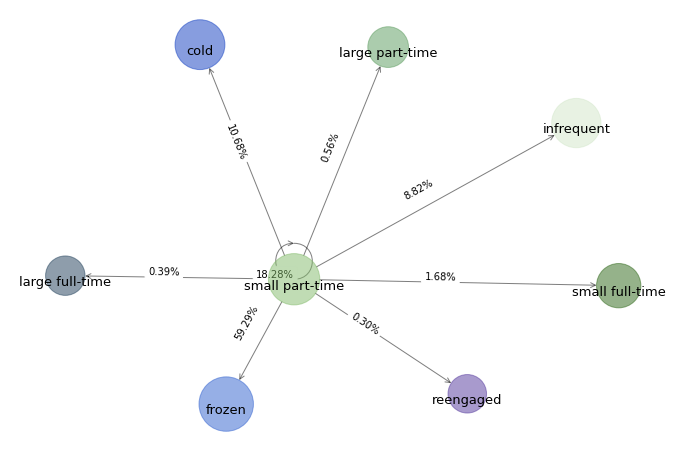

In [10]:
figure, ax = plt.subplots(figsize=(12,8))
pos = nx.spring_layout(DG)
#pos = nx.circular_layout(DG)

node_sizes = 280 * np.log(edges['weight'].to_numpy())

node_labels = dict(nodes[['id','label']].values)
edge_labels = dict(zip(DG.edges, (edges['weight'] /
                                  edges['weight'].sum()) \
                       .apply(lambda x: f'{x:.2%}')))
edge_colors = ['#82bA6A','#53379C',
               '#1E3D58','#D2E6C9',
               '#599A5C','#103DC0',
               '#2C6616','#2F60CE']

nx.draw_networkx_nodes(
    DG,
    pos,
    node_size=node_sizes,
    node_color=edge_colors,
    alpha=0.5,
    ax=ax
)
nx.draw_networkx_edges(
    DG,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=12,
    edge_color='black',
    width=1,
    alpha=0.5,
    ax=ax  
)
nx.draw_networkx_labels(
    DG,
    pos,
    font_size=13,
    labels=node_labels,
    verticalalignment='top',
    ax=ax
)
nx.draw_networkx_edge_labels(
    DG,
    pos,
    edge_labels=edge_labels,
    font_size=10,
    verticalalignment='bottom',
    horizontalalignment='right'
)

ax.set_axis_off()
plt.show()

# Visualizing Transitions in Viewer Lifecycle Stages

In [3]:
df = pd.read_csv('lifecycle_test.csv')

In [4]:
df.loc[df['previous_type'] == 'established', 'previous_type'] = 'regular'
df.loc[df['previous_type'] == 'thawing', 'previous_type'] = 'occasional'

In [5]:
df.loc[df['type'] == 'established', 'type'] = 'regular'
df.loc[df['type'] == 'thawing', 'type'] = 'occasional'

In [6]:
df.drop(index=[1,5], inplace=True)

In [7]:
df = df.append(pd.DataFrame([['born', 'born', 0],
                             ['churned', 'churned', 0]], columns=df.columns),
               ignore_index=True)

In [8]:
df

,previous_type,type,num
0,born,new,1677777
1,cold,cold,54651522
2,cold,frozen,2361169
3,cold,reengaged,638642
4,regular,regular,4942127
5,regular,cold,46142
6,frozen,frozen,314797532
7,frozen,churned,1804402
8,frozen,reengaged,325604
9,new,new,14049148


Create all factorial combinations of transition states with zeros

In [9]:
from itertools import product

In [37]:
df = pd.DataFrame(product(df['previous_type'].unique(),
                          df['type'].unique()), columns=['previous_type', 'type']) \
         .merge(df, how='left', on=['previous_type', 'type']) \
         .fillna(0) \
         .astype({'num': int})

In [149]:
pivoted = df.pivot_table(index='previous_type', columns='type').droplevel(0, axis=1).reset_index()

In [151]:
labels = {key:value for key, value in enumerate(pivoted['previous_type'].tolist(), 1)}

Convert to matrix with stages as row names

In [153]:
pivoted = pivoted.iloc[:,1:]
pivoted.index = range(1, len(pivoted)+1)
pivoted.columns = range(1, len(pivoted)+1)

Cast as numeric and scale to percentages

In [147]:
pivoted.div(pivoted.sum(axis=1), axis=0) * 100

,1,2,3,4,5,6,7,8
1,0.0,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000000,94.796632,4.095602,0.000000,0.000000,1.107766,0.000000
4,0.0,0.569342,0.000000,99.327920,0.000000,0.000000,0.102738,0.000000
5,0.0,0.000000,15.065127,0.000000,84.822043,0.000000,0.000000,0.112829
6,0.0,0.000000,8.905965,0.000000,0.000000,90.770233,0.000000,0.323802
7,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
8,0.0,0.000000,0.925010,0.000000,0.000000,0.000000,0.000000,99.074990


In [81]:
DG = nx.from_pandas_adjacency(pivoted, nx.DiGraph())

In [96]:
nx.info(DG)

'DiGraph with 8 nodes and 16 edges'

In [159]:
edges = pivoted.div(pivoted.sum(axis=1), axis=0)

In [160]:
edges

,1,2,3,4,5,6,7,8
1,0.0,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000000,0.947966,0.040956,0.00000,0.000000,0.011078,0.000000
4,0.0,0.005693,0.000000,0.993279,0.00000,0.000000,0.001027,0.000000
5,0.0,0.000000,0.150651,0.000000,0.84822,0.000000,0.000000,0.001128
6,0.0,0.000000,0.089060,0.000000,0.00000,0.907702,0.000000,0.003238
7,0.0,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
8,0.0,0.000000,0.009250,0.000000,0.00000,0.000000,0.000000,0.990750


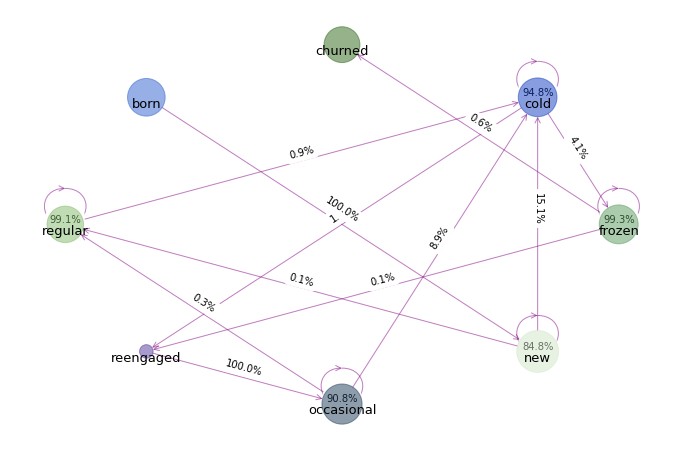

In [181]:
figure, ax = plt.subplots(figsize=(12,8))
#pos = nx.circular_layout(DG)
#pos = nx.planar_layout(DG)
#pos = nx.random_layout(DG)
pos = nx.shell_layout(DG)
#pos = nx.spiral_layout(DG)
#pos = nx.spring_layout(DG)

node_sizes = 80 * np.log(pivoted.sum(axis=1).to_numpy() * 10 + 10)
edge_colors = ['#82bA6A','#53379C',
               '#1E3D58','#D2E6C9',
               '#599A5C','#103DC0',
               '#2C6616','#2F60CE']
node_labels = labels
edge_labels = {edge: f'{edges.loc[edge]:.1%}' for edge in DG.edges}

nx.draw_networkx_nodes(
    DG,
    pos,
    node_size=node_sizes,
    node_color=edge_colors,
    alpha=0.5,
    ax=ax
)

nx.draw_networkx_edges(
    DG,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=13,
    edge_color='purple',
    width=1,
    alpha=0.5,
    ax=ax  
)

nx.draw_networkx_labels(
    DG,
    pos,
    font_size=13,
    labels=node_labels,
    verticalalignment='top',
    ax=ax
)

nx.draw_networkx_edge_labels(
    DG,
    pos,
    edge_labels=edge_labels,
    font_size=10,
    verticalalignment='bottom',
    horizontalalignment='center'
)

ax.set_axis_off()
plt.show()